# Assignment 2: K-means

1. Choose 3 to 6 features. Explain the choice. 
2. Apply K-means:
At K=5
At K=9
In both cases: 10 or more random initializations, choose the best solution over the K-means criterion; present it in a table
3. Interpret each found partition by using features from the data table – as instructed in the lecture slides. Explain why you consider one of them better than the other in this perspective.

In [151]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn import metrics

%matplotlib inline
sns.set()

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["figure.figsize"] = (12,8)

In [51]:
# Load data
hero_agg = pd.read_csv('aggregated_superheroes.csv',sep=';')

# Check NaN values
print("NaN:", hero_agg.isna().values.any()) 
# Check duplicates in names
print("Duplicates:", hero_agg.name.duplicated().any()) 
hero_agg = hero_agg.set_index('name')
hero_agg.head()

NaN: False
Duplicates: False


,intelligence,strength,speed,durability,power,combat,Gender,Eye color,Race,Hair color,Height,Publisher,Alignment,Weight,Dexterity & speed,Healing,Weapon abilities,Brainpower,Energy powers,Sences & Thermal abilities,Psychic abilities,Body features,Space abilities,Defensive abilities,Similiar to magic,God-like abilities
name,,,,,,,,,,,,,,,,,,,,,,,,,,
A-Bomb,38,100,17,80,24,64,Male,yellow,Human,No Hair,203.0,Marvel Comics,good,441.0,1,2,0,0,0,0,0,3,0,1,0,0
Abe Sapien,88,28,35,65,100,85,Male,blue,Icthyo Sapien,No Hair,191.0,Dark Horse Comics,good,65.0,3,2,2,1,0,2,1,5,0,0,0,0
Abin Sur,50,90,53,64,99,65,Male,blue,Ungaran,No Hair,185.0,DC Comics,good,90.0,0,0,0,0,1,0,0,0,0,0,0,0
Abomination,63,80,53,90,62,95,Male,green,Human / Radiation,No Hair,203.0,Marvel Comics,bad,441.0,2,2,0,1,0,0,0,2,0,0,1,0
Absorbing Man,38,80,25,100,98,64,Male,blue,Human,No Hair,193.0,Marvel Comics,bad,122.0,0,1,0,0,1,2,0,2,0,3,2,0


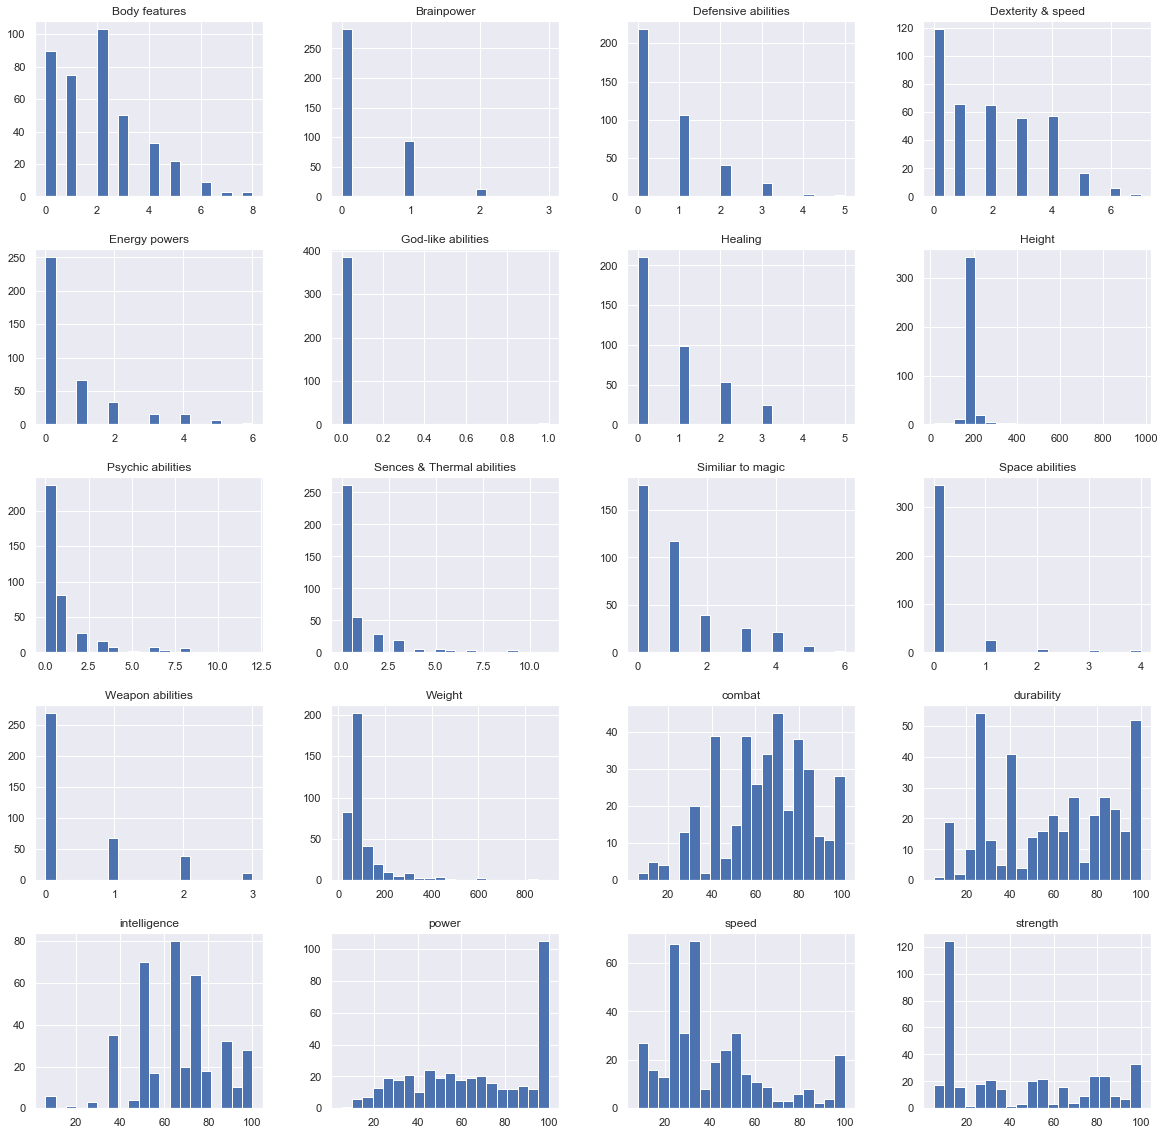

In [349]:
# Plot & save quantitative features distributions
hero_agg.hist(figsize=(20,20),bins=20)
plt.savefig('numerical_histograms.png')

In [350]:
# Choose 6 features from the dataset
cluster_features = ['Height','Weight', 'Body features', 'Dexterity & speed', 'Energy powers', 'Sences & Thermal abilities']
hero_agg[cluster_features].head()

,Height,Weight,Body features,Dexterity & speed,Energy powers,Sences & Thermal abilities
name,,,,,,
A-Bomb,203.0,441.0,3,1,0,0
Abe Sapien,191.0,65.0,5,3,0,2
Abin Sur,185.0,90.0,0,0,1,0
Abomination,203.0,441.0,2,2,0,0
Absorbing Man,193.0,122.0,2,0,1,2


We need to standardize our features. Let’s do it by centering features by their mean and normalize by their range:

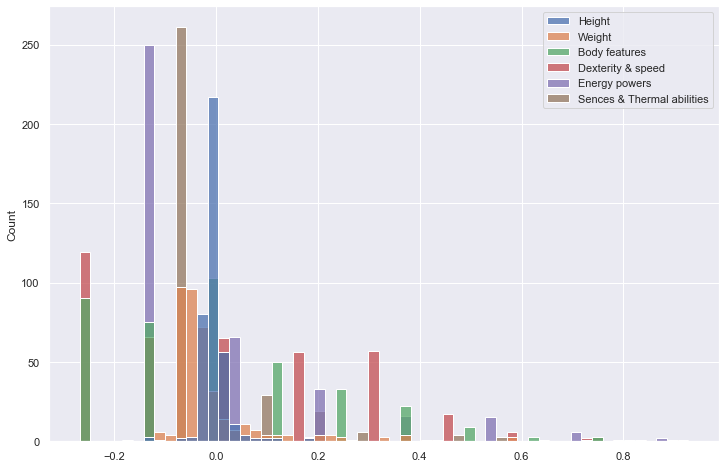

In [360]:
# Each feature centered by its mean and normalized by its range
def MeanRangeScale(df):
    return (df-df.mean())/(df.max()-df.min())

scaled_data = MeanRangeScale(hero_agg[cluster_features])
sns.histplot(scaled_data)

Let's write some support functions for clustering. One for highlighting big values by absolute value in pandas table and the second - that calculate metrics for simple clustering interpretation(description presented below).

In [338]:
# Highlight too big positive or too low negative values in pandas row by some border(=35)
def highlight_big_difference(row, border=35):
    colors = []
    for value in row:
        if value > border:
            colors.append('background-color: lightgreen')
        elif value < -border:
            colors.append('background-color: tomato')
        else:
            colors.append('')
            
    return colors

# Calculate metrics for cluster interpretation
def cluster_interpretation(clusters):
    # Calculate global & cluster means
    cluster_means = hero_agg[cluster_features].groupby(clusters).mean()
    grand_means = hero_agg[cluster_features].mean()
    clusters_info = {}
    
    # Calculate differences and merge all numbers in one table
    for cluster in range(n_clusters):
        difference = cluster_means.iloc[cluster] - grand_means
        relative_difference = difference/grand_means*100
        metrics = {'Grand mean': grand_means,
                   'Cluster mean': cluster_means.iloc[cluster],
                   'Difference': difference,
                   'Relative difference,%': relative_difference}
        cluster_name = f'Cluster {cluster}'
        clusters_info[cluster_name] = pd.concat(metrics,axis=1)

    cluster_metrics = pd.concat(clusters_info)
    return cluster_metrics.style.apply(highlight_big_difference, subset=['Relative difference,%']).set_precision(2)

Now let's run K-means algorithm with parameters - 5 clusters, 20 random initializations and also set random_state, so we will get the same results on every run. We can see that algorithm converges rather quick - after 9 iterations and inertia become ~30.6. Below there is detailed table that can help to interpret results of clustering. It has several columns: 
- Grand mean - mean on the whole data for every feature
- Cluster mean - each cluster's mean for every feature
- Difference - difference between whole data mean and cluster's mean for every feature(Grand mean - Cluster mean)
- Relative difference(%) - percent, that show how much cluster's mean differs from global data mean for every feature
$$\frac{Grand\,mean - Cluster\,mean}{Grand\,mean}*100\%$$

Color in the last column shows values that are rather big(>35%) - green or rather small(<-35%) - red.

In [341]:
# K-means 5
n_clusters = 5
clustering = KMeans(n_clusters=n_clusters,init='random',n_init=20, random_state=42,algorithm='full')
clusters_5 = clustering.fit_predict(scaled_data)
print('Number of iterations before converge(max_iter=300) :', clustering.n_iter_)
print('Inertia:', clustering.inertia_)
cluster_interpretation(clusters_5)

Number of iterations before converge(max_iter=300) : 9
Inertia: 30.607964002810938


Let's also print the number of superheroes in each cluster

In [357]:
 hero_agg[cluster_features].groupby(clusters_5).Height.count()

0    117
1     78
2     50
3    108
4     35
Name: Height, dtype: int64

That time let's run K-means algorithm with parameters - 9 clusters, 20 random initializations and also set random_state. We can see that algorithm converges less quick than previous - after 22 iterations and inertia become ~20.3. 

In [342]:
# K-means 9
n_clusters = 9
clustering = KMeans(n_clusters=n_clusters,init='random',n_init=20, random_state=42,algorithm='full')
clusters_9 = clustering.fit_predict(scaled_data)
print('Number of iterations before converge(max_iter=300) :', clustering.n_iter_)
print('Inertia:', clustering.inertia_)
cluster_interpretation(clusters_9)

Number of iterations before converge(max_iter=300) : 22
Inertia: 20.323677914326105


Let's also print the number of superheroes in each cluster

In [358]:
 hero_agg[cluster_features].groupby(clusters_9).Height.count()

0    69
1    61
2    48
3    32
4    12
5    35
6    15
7    89
8    27
Name: Height, dtype: int64

We can also use Principal Component Analysis for simple transformation of our data to 2-D space and then look on clusters on the plot:

In [328]:
# Perform PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(scaled_data)
pca.explained_variance_ratio_

array([0.44620598, 0.22793106])

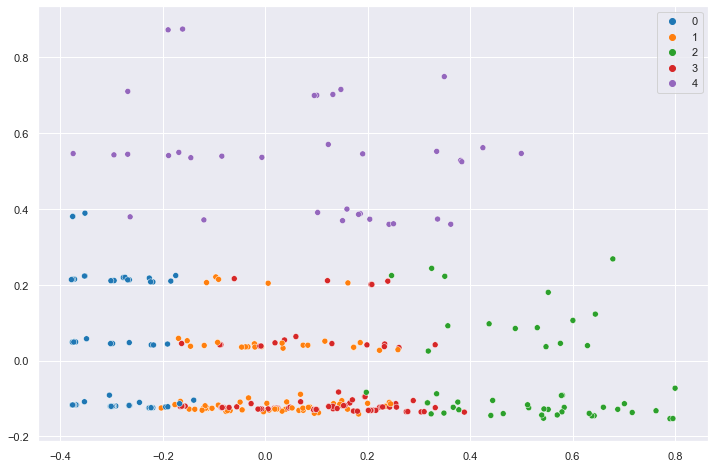

In [343]:
# Colored clusters(5 clusters) after PCA - looks rather good
sns.scatterplot(data_pca[:,0],data_pca[:,1],hue=clusters_5,palette='tab10')

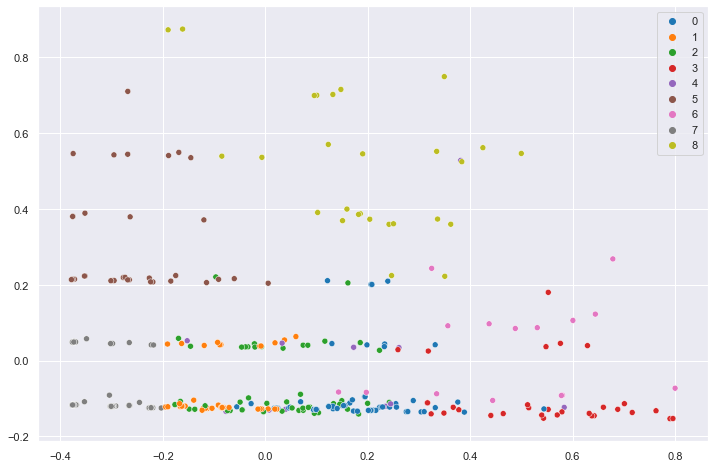

In [344]:
# Colored clusters(9 clusters) after PCA - looks like some clusters are a bit mixed
sns.scatterplot(data_pca[:,0],data_pca[:,1],hue=clusters_9,palette='tab10')

# Assignment 3. Bootsrap

Take one of the partitions found in the previous work.

1. Take a feature, find the 95% confidence interval for its grand mean by using bootstrap
2. Compare the within-cluster means for one of the features between two clusters using bootstrap
3. Take a cluster, and compare the grand mean with the within-cluster mean for the feature by using bootstrap

Note: each application of bootstrap should be done in both, pivotal and non-pivotal, versions

In [363]:
hero_agg[cluster_features].groupby(clusters_5).mean()

,Height,Weight,Body features,Dexterity & speed,Energy powers,Sences & Thermal abilities
0,179.051282,74.658120,0.512821,0.145299,0.572650,0.136752
1,200.188462,177.679487,3.000000,1.128205,0.410256,0.705128
2,185.880000,135.240000,4.720000,4.280000,0.400000,3.020000
3,181.166667,98.805556,1.527778,3.000000,0.231481,0.481481
4,201.657143,119.428571,2.200000,2.400000,3.942857,1.057143


Let's write a function for generating random samples from our data with the same size as the original data. Let's do it for example K=5000 times and calculate mean value each time. This way we get distribution close to normal distribution. Then we can plot the original distribution and new distribution of means. After applying our function to feature Weight we can see that the last distribution really looks good and bell-shaped.

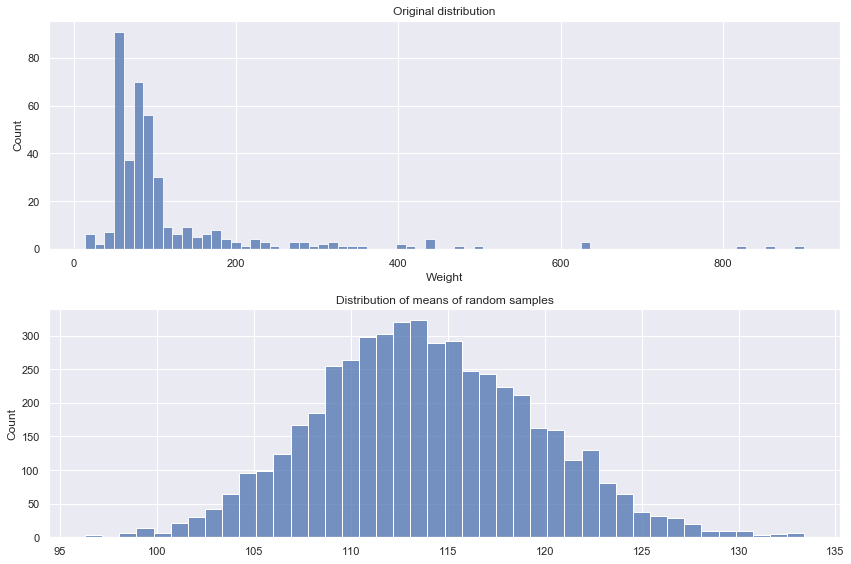

In [482]:
def bootstrap(df, K = 5000):
    # Generate samples of size N and calculate their means
    N = df.shape[0]
    random_indexes = np.random.randint(0,N,(K,N))
    samples_means = [df.iloc[random_indexes[i]].mean() for i in range(K)]
    
    # Plot original distribution of df
    fig, ax = plt.subplots(2,1)
    sns.histplot(df,ax=ax[0])
    ax[0].set_title('Original distribution')
    
    # Plot distribution of means of random samples of df
    sns.histplot(samples_means,ax=ax[1])
    ax[1].set_title('Distribution of means of random samples')
    plt.tight_layout()
    
    return samples_means

samples_means = bootstrap(hero_agg['Weight'],5000)

Now, as we have almost normal distribution it is simple to calculate 95% confidence interval for mean. There are 2 main methods to do it. First is pivotal method - we calculate mean and standard deviation and define confidence interval as $\mu \pm 1.96*\sigma$. The second is non-pivotal method - as we know the fraction of values that should be lower than the left boarder of confidence interval - about 2.5% and greater than the right boarder of confidence interval - about 97.5%, we can find the values that are in the sample at these locations - 2.5% * K(=5000) and 97.5% * K(=5000).

In [483]:
def get_boundaries(means, method_type = 'pivot'):
    # Pivotal method
    if method_type == 'pivot':
        means_mean = np.mean(means)
        means_std = np.std(means)
        left_border = means_mean - 1.96*means_std
        right_border = means_mean + 1.96*means_std
        
    # Non-pivotal method
    else:
        K = len(means)
        means_sorted = sorted(means)
        left_border = means_sorted[int(K*0.025+1)]
        right_border = means_sorted[int(5000-K*0.025)]
        
    return round(left_border,3), round(right_border,3)

Let's calculate 95% confidence interval for grand mean of feature Weight. Looks like intervals from both methods are rather close to each other.

In [484]:
print('95% interval from pivotal method:', get_boundaries(samples_means))
print('95% interval from non-pivotal method:', get_boundaries(samples_means, 'non-pivot'))

95% interval from pivotal method: (102.816, 124.984)
95% interval from non-pivotal method: (103.361, 125.43)


Let's compare within-cluster means of Cluster 0 and Cluster 1 for feature Weight.

In [485]:
# Get ids of elements from Cluster 0 & Cluster 1
cluster0 = np.argwhere(clusters_5==0)[:,0]
cluster1 = np.argwhere(clusters_5==1)[:,0]

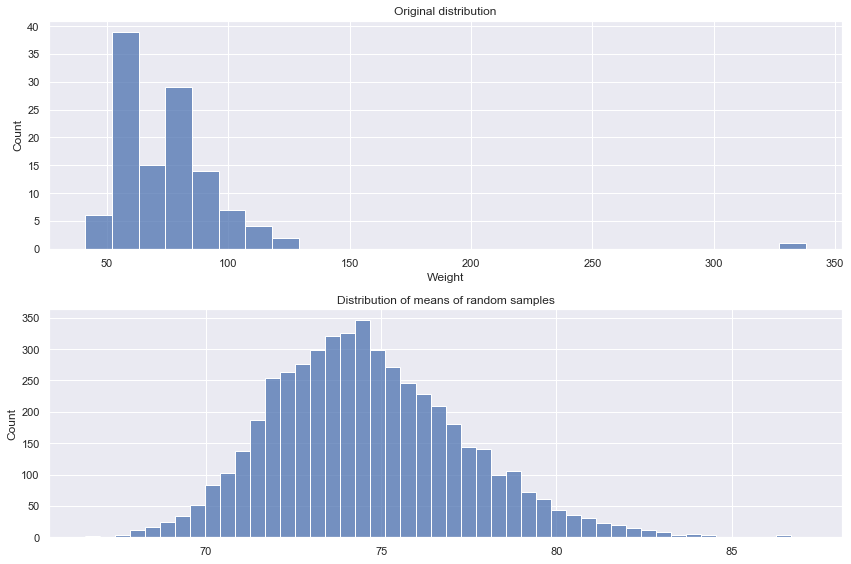

In [492]:
# Look on Cluster 0 distributions
cluster0_means = np.array(bootstrap(hero_agg['Weight'][cluster0],5000))

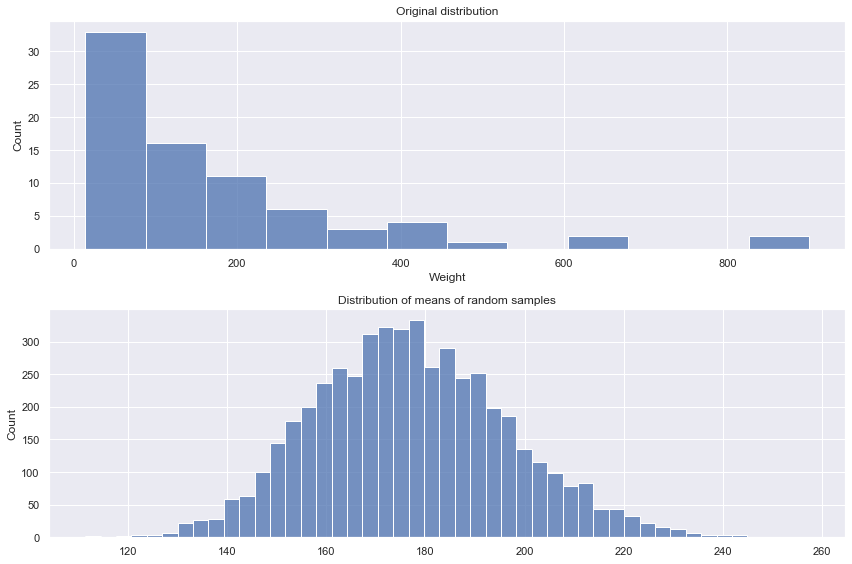

In [493]:
# Look on Cluster 1 distributions
cluster1_means = np.array(bootstrap(hero_agg['Weight'][cluster1],5000))

Let's calculate 95% confidence interval for (mean of Cluster 1 - mean of Cluster 0):

In [494]:
print('95% interval from pivotal method:', get_boundaries(cluster1_means - cluster0_means))
print('95% interval from non-pivotal method:', get_boundaries(cluster1_means - cluster0_means, 'non-pivot'))


95% interval from pivotal method: (63.547, 141.503)
95% interval from non-pivotal method: (66.316, 144.466)


Let's compare grand mean for feature Weight and within-cluster for Cluster 1.

In [496]:
print('95% interval from pivotal method:', get_boundaries(samples_means - cluster1_means))
print('95% interval from non-pivotal method:', get_boundaries(samples_means - cluster1_means, 'non-pivot'))

95% interval from pivotal method: (-103.572, -22.961)
95% interval from non-pivotal method: (-105.861, -25.533)
